## Reporting Minimization

You can report the status of [simulation.minimizeEnergy()](http://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html?#openmm.app.simulation.Simulation.minimizeEnergy) using a [MinimizationReporter](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.MinimizationReporter.html). Note that `MinimizationReporter` was introduced in OpenMM 8.1.

The syntax for doing this is somewhat different to typical OpenMM functionality. You will need to define a subclass of `MinimizationReporter` that has a `report()` method. Within this report method you can write code to take any action you want. The report method is called every iteration of the minimizer. Read the [API documentation](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.MinimizationReporter.html) for more explanation.

First we will create a test system then we will show an example.

In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

pdb = PDBFile('villin.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

Below is an example which prints the current energy to the screen and saves the energy to an array for plotting. The comments explain each part.

In [2]:

# The class can have any name but it must subclass MinimizationReporter.
class MyMinimizationReporter(MinimizationReporter):

    # within the class you can declare variables that persist throughout the
    # minimization

    energies = [] # array to record progress

    # you must override the report method and it must have this signature.
    def report(self, iteration, x, grad, args):
        '''
        the report method is called every iteration of the minimization.
        
        Args:
            iteration (int): The index of the current iteration. This refers 
                             to the current call to the L-BFGS optimizer.
                             Each time the minimizer increases the restraint strength, 
                             the iteration index is reset to 0.

            x (array-like): The current particle positions in flattened order: 
                            the three coordinates of the first particle, 
                            then the three coordinates of the second particle, etc.

            grad (array-like): The current gradient of the objective function 
                               (potential energy plus restraint energy) with 
                               respect to the particle coordinates, in flattened order.

            args (dict): Additional statistics described above about the current state of minimization. 
                         In particular:
                         “system energy”: the current potential energy of the system
                         “restraint energy”: the energy of the harmonic restraints
                         “restraint strength”: the force constant of the restraints (in kJ/mol/nm^2)
                         “max constraint error”: the maximum relative error in the length of any constraint

        Returns:
            bool : Specify if minimization should be stopped.
        '''

        # Within the report method you write the code you want to be executed at 
        # each iteration of the minimization.
        # In this example we get the current energy, print it to the screen, and save it to an array. 

        current_energy = args['system energy']

        if iteration % 100 == 0: # only print to screen every 100 iterations for clarity of webpage display
            print(current_energy)

            
        self.energies.append(current_energy)

        # The report method must return a bool specifying if minimization should be stopped. 
        # You can use this functionality for early termination.
        return False

We now create an instance of the reporter and minimize the system with the reporter attached.

-142752.48304234218


-172627.8759880447


-176452.3182709929


-178135.03887811248


-179021.65299998067


-179464.18214726035


-179779.87519970935


-130436.52345041242


-153966.6395773836


-158902.04247547252


-161592.10923615226


-162997.04272783094


-164016.6547813879


-164601.7442716647


-165188.52195152274


-165521.5690783736


-165953.50986168376


-166352.87796949872


-166657.3767969182


-166823.82724596033


-167012.26874501965


-167205.01301048725


-167365.93878932844


-167472.09883726703


-167582.69806256815


-167686.75808841558


-167750.1221092277


-167824.66060309132


-167869.61506821163


-167926.17122118786


-167994.45285707313


-168051.76007310033


-168098.01418802422


-168167.58436954892


-168231.8025225762


-168296.9085149197


-168366.62730021146


-168404.93831564693


-168437.71022325204


-168480.75373260965
-167542.6687641211


-167203.86174800337


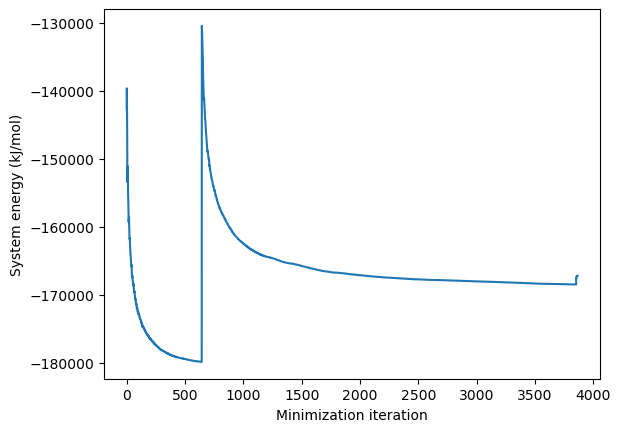

In [3]:
reporter = MyMinimizationReporter()

simulation.minimizeEnergy(reporter=reporter)

import matplotlib.pyplot as plt
plt.plot(reporter.energies)
plt.ylabel("System energy (kJ/mol)")
plt.xlabel("Minimization iteration")
plt.show()

You will notice that the energy does not change continuously and does not always decrease. This is because the L-BFGS algorithm used by the minimizer does not support constraints. The minimizer therefore replaces all constraints with harmonic restraints, then performs unconstrained minimization of a combined objective function that is the sum of the system’s potential energy and the restraint energy. Once minimization completes, it checks whether all constraints are satisfied to an acceptable tolerance. It not, it increases the strength of the harmonic restraints and performs additional minimization. If the error in constrained distances is especially large, it may choose to throw out all work that has been done so far and start over with stronger restraints. This has several important consequences:

- The objective function being minimized not actually the same as the potential energy. 
- The objective function and the potential energy can both increase between iterations. 
- The total number of iterations performed could be larger than the number specified by the maxIterations argument, if that many iterations leaves unacceptable constraint errors. 
- All work is provisional. It is possible for the minimizer to throw it out and start over. 